## IML_Projet_6
Classez des images à l'aide d'algorithmes de Deep Learning

Ce note book contient : 
- La creation et le test de mon propre reseau de neurone CCN 

## Installation libraries

## Data mount drive folder

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs


In [0]:
!ls

01_OC_IML_Project_6_explorations.ipynb	__pycache__
my_utils_dogs.py			README.md


## Import

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import os

import re

import pickle

import time

from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import scipy.io as sio

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
import cv2 as cv

import tensorflow
print(tensorflow.__version__)

# keras from scratch
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
# keras already trained
from keras.applications.vgg16 import VGG16
# keras image preparation
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
# decode prediction
from keras.applications.vgg16 import decode_predictions
# for training keras model : optimizers
from keras import optimizers
# Keras model base
from keras.models import Model

import json

# ne marche pas (une modif d'une fonction d'un module ne se répercute pas)
# import user module
#from my_utils_dogs import find_breed


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


1.15.0


Using TensorFlow backend.


## Definitions

In [0]:
path_data = '/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/'
path_file_list = 'lists/file_list.mat'
path_test_list = 'lists/test_list.mat'
path_train_list = 'lists/train_list.mat'
path_test_data = 'test_data.mat'
path_train_data = 'train_data.mat'

paths_images_all_breeds = ['Images/n02107683-Bernese_mountain_dog/',
                     'Images/n02088094-Afghan_hound/',
                     'Images/n02096051-Airedale/',
                     'Images/n02090721-Irish_wolfhound/',
                     'Images/n02091831-Saluki/',
                     'Images/n02092002-Scottish_deerhound/',
                     'Images/n02096294-Australian_terrier/',
                     'Images/n02095889-Sealyham_terrier/',
                     'Images/n02095570-Lakeland_terrier/',
                     'Images/n02110185-Siberian_husky/']

nb_breeds = 3
paths_images_breeds = paths_images_all_breeds[:nb_breeds]

path_img_test = path_data + 'Images/n02085620-Chihuahua/' + "n02085620_242.jpg"

path_df_dogs = path_data + 'df_dogs.pkl'
path_X_images = path_data + 'X_images.pkl'
path_Y_images = path_data + 'Y_images.pkl'

name_new_model_2 = 'VGG16_TL_class_01'
path_model_2 = path_data +  name_new_model_2 + '.pkl'

path_df_results = path_data + 'df_results.pkl'

path_imagenet = path_data + 'Images/imagenet_class_index.json'

train_percent = 0.7

## Useful functions

In [0]:
def separate_train_by_class(df_dogs, train_percent=0.7):

  '''
  Separate TRAIN / TEST set per breed

  by default train_percent = 0.7

  add "Train" column to df_dogs

  example : df_dogs = separate_train_by_class(df_dogs, train_percent=0.7)
  '''

  df_dogs['Train'] = False
  for id_class in df_dogs["class"].unique():
    np.random.seed(0)
    indices_permut = np.random.permutation(\
      df_dogs[df_dogs["class"] == id_class].shape[0])
    indices_permut_train = \
      indices_permut[0:np.int(len(indices_permut)*train_percent)]
    index_train  = df_dogs[df_dogs["class"] == \
                         id_class].iloc[indices_permut_train].index
    df_dogs.loc[index_train, "Train"] = True

  v= df_dogs["Train"].value_counts()
  print("% of Train : {:.2f} %".format(100*v.loc[True]/sum(v)))
  print(df_dogs["Train"].value_counts())

  return df_dogs

In [0]:
def import_data(paths_images_breeds, train_percent=0.7, force_import=False,
                path_df_dogs=path_df_dogs, path_X_images=path_X_images):
  '''
  Import data from images on disk

  3 possibilites if force_import = False:
  (1) no data on disk, no data in memory :
    - create df_dogs & X from image files 
    - separate train / test set for df_dogs
  (2) data pickled on disk, no data in memory : 
    - load data from pickled files for df_dogs & X
    - separate train / test set for df_dogs
  (3) data in memory
    - use df_dogs & X from memory 
    - separate train / test set for df_dogs
    - save df_dogs & X on disk
  
  if force_import = True, only  read from image files (1) is possible.

  example: import from memory or already pickled files on disk, with 70% train: 
    df_dogs, X, dict_breed = import_data(paths_images_breeds)
  
  '''
  # import from already processed pickle files on disk
  try:
    if force_import == False:
      df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
      df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)
      return df_dogs, X, dict_breed 
  except:
    # if not in memory and not on disk
    pass # continue with importation from images files on disk
  
  # import from image files on disk
  df_dogs = pd.DataFrame(columns=["filename", "path", "breed", "class"])
  # read images in source folders
  X=None
  for id, path_curr in enumerate(paths_images_breeds):
    breed_curr = re.findall('\w+(?=/$)', path_curr)
    print(breed_curr)
    for filename in os.listdir(path_data + path_curr):
      df_add = pd.DataFrame(columns=["filename", "path", "breed", "class"], 
                          index =[0])
      df_add["filename"] = filename
      df_add["path"] = path_data + path_curr + filename
      df_add["breed"] = breed_curr
      df_add["class"] = id
      df_dogs = df_dogs.append(df_add, ignore_index=True)
      # create X image matrix
      img = load_img(df_add["path"].values[0], 
               target_size=(224, 224))  # Charger l'image
      img = img_to_array(img)  # Convertir en tableau numpy
      if X is None:
        X = img[np.newaxis, :]
      X = np.concatenate((X, img[np.newaxis, :]), axis=0)

  # seperate train/test 
  df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)   
  # preprocess image data for VGG-16
  X = preprocess_input(X)

  # find breed name
  dict_breed = dict()
  for id_class in df_dogs["class"].unique(): 
    dict_breed[id_class] = df_dogs[df_dogs["class"] == \
                                 id_class]["breed"].values[0]
  
  # save on disk
  save_data(df_dogs, path_df_dogs, X, path_X_images)

  return df_dogs, X, dict_breed

In [0]:
def save_data(df_dogs, path_df_dogs, X, path_X_images):
  '''
  Save data on disk : df_dogs & X images

  example : save_data(df_dogs, path_df_dogs, X, path_X_images)

  '''
  joblib.dump(df_dogs, path_df_dogs, compress=True)
  print("df_dogs Saved here:\n{}".format(path_df_dogs))
  joblib.dump(X, path_X_images, compress=True)
  print("X Saved here:\n{}".format(path_X_images))

In [0]:
def load_data_breeds(force_reload=False, path_df_dogs=path_df_dogs,
                     path_X_images=path_X_images):
  '''
  Load data from disk if variable df_dogs & X is not available in memory

  Optional parameter force_reload can be use to force reload in any case.

  example : df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
  '''
  # df_dogs
  if force_reload == False:
    try:
      df_out = df_dogs
    except:
      print("Loading from disk df_dogs...")
      df_out = joblib.load(path_df_dogs)
  else:
    print("Loading from disk df_dogs...")
    df_out = joblib.load(path_df_dogs)
  # X images
  if force_reload == False:
    try:
      X_out = X
    except:
      print("Loading from disk X images...")
      X_out = joblib.load(path_X_images)
  else:
    print("Loading from disk X images...")
    X_out = joblib.load(path_X_images)

  # find breed name
  dict_breed = dict()
  for id_class in df_out["class"].unique(): 
    dict_breed[id_class] = df_out[df_out["class"] == \
                                 id_class]["breed"].values[0]
  
  return df_out, X_out, dict_breed

In [0]:
def create_separate_features(df_dogs, X, list_X_classes=None,
                             list_Y_classes=None):
  '''
  Seperate train/test matrix of images to be use by CNN Models
  
  example : 
    X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs, X)
  '''
  # select from df_dogs & X only list of breed : list_X_classes
  def fun_class_ok(classNum):
    if classNum in list_X_classes:
      return True
    else:
      return False
  
  if list_X_classes is not None:
    df_in = df_dogs
    df_in["class_OK"] = False
    df_in["class_OK"] = df_dogs["class"].apply(fun_class_ok)

    df_in = df_in[df_in["class_OK"] == True]
  else:
    df_in = df_dogs
  
  # seperate train/test matrix of images 
  index_train = df_in[df_in["Train"] == True].index
  index_test = df_in[df_in["Train"] == False].index
  X_train = X[index_train,:,:,:]
  X_test = X[index_test,:,:,:]

  # prepare for Y the classes
  if list_Y_classes is None:
    lb = LabelBinarizer()
    lb.fit(df_in["class"].tolist())
    Y_train = lb.transform(df_in[df_in["Train"] == True]["class"].tolist())
    Y_test =  lb.transform(df_in[df_in["Train"] == False]["class"].tolist())
  else:
    # use list_Y_classes
    # lb function
    def lb(x):
      return label_binarize(x, classes=list_Y_classes)
    # transform train set
    Y_train = lb(
        df_in[df_in["Train"] == True]["breed"].tolist())
    # transform test set
    Y_test = lb(
        df_in[df_in["Train"] == False]["breed"].tolist())

  return X_train, X_test, Y_train, Y_test, lb

In [0]:
def get_imagenet_classes():
    # get labels
    with open(path_imagenet) as json_data:
      class_idx = json.load(json_data)
      idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
      # PATCH : to correct double classes
      idx2label[idx2label.index("crane")] = "crane_0"
      idx2label[idx2label.index("maillot")] = "maillot_0"
    return idx2label

In [0]:
def load_prepare_img(path_img):
  '''
  Load image from path and prepare for VGG-16
  return : 
    img : np array
    img_raw : Image from PIL

  example : img, img_raw = load_prepare_img(path_img)
  '''

  img_raw = load_img(path_img, target_size=(224, 224))  # Charger l'image
  img = img_to_array(img_raw)  # Convertir en tableau numpy
  img = img[np.newaxis, :]
  img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
  img_raw
  return img, img_raw

In [0]:
def predict_breed_from_one_path(path_img, mdl):
  '''
  Predict Breed Name from one image path

  example : breedName = predict_breed_from_one_path(path_img, model)
  '''
  print(path_img)
  img, img_raw = load_prepare_img(path_img)
  y = mdl.predict(img) 
  if y.shape[1] >= 1000:
    breedName = decode_predictions(y, top=3)[0]
    print('VGG-16 : Top 3 :', breedName)
  else:
    print("Probabilities : ", y)
    breedName = find_breed(y, dict_breed)
  print(breedName)
  return breedName, img_raw

In [0]:
def evaluate_mdl_scorings(Y_train, Y_train_pred,
                          Y_test, Y_test_pred, 
                          timing_fit=0, timing_pred=0):
    dict_scores = dict()
    
    #calculate over same splits f1_micro mean & std
    #cv_lda

    '''
    f1_splits = []
    # on splits test
    for train_index, test_index in cv_lda.split(enc_lda_y_train):
        f1_splits.append(f1_score(enc_lda_y_train[test_index], 
                                  enc_lda_ypred_train[test_index], 
                                  average='micro'))  
    dict_scores["f1_splits_test"] = np.mean(f1_splits)
    dict_scores["f1_splits_test_std"] = np.std(f1_splits)
    '''
    
    # transform as class number 
    Y_train_pred_num = np.argmax(Y_train_pred, axis=1)
    Y_train_num = np.argmax(Y_train, axis=1)
    Y_test_pred_num = np.argmax(Y_test_pred, axis=1)
    Y_test_num = np.argmax(Y_test, axis=1)

    dict_scores["acc_train"] = accuracy_score(Y_train_num, Y_train_pred_num)

    dict_scores["acc_test"] = accuracy_score(Y_test_num, Y_test_pred_num)

    dict_scores["t_fit"] = timing_fit
    dict_scores["t_pred"] = timing_pred
    
    return pd.Series(data = dict_scores)

def add_score(df_results, series_scores, model_name):
    
    df_results_add = pd.DataFrame(data=series_scores, columns=[model_name]).T
    
    if df_results is None: # create table
        print('create df_results')
        df_results = df_results_add.copy()
    else: # update or add line
        try:
            # ligne existe alors on efface l'ancienne ligne  ?
            df_results = df_results.drop(index=model_name)                                
            print('update line')
        except:
            # n'existe pas
            print('add line')
            
        # on ajoute la ligne
        df_results = df_results.append(df_results_add)
        
    return df_results

In [0]:
def find_breed(y, dict_breed):
    '''
    Find Breed Name from y output of CNN model
    breed_name = find_breed(y, dict_breed)
    '''
    return dict_breed[np.argmax(y)]

## Data importation

### Load images of dogs from different folders

In [0]:
force_import = False # only once

In [93]:
# import data from disk images & save them into memory and DISK !
df_dogs, X, dict_breed = import_data(paths_images_all_breeds, 
                                     train_percent=train_percent, 
                                     force_import=force_import)
# check
print("Image matrix size : ", X.shape)
df_dogs.head()

% of Train : 69.80 %
True     1463
False     633
Name: Train, dtype: int64
Image matrix size :  (2097, 224, 224, 3)


,filename,path,breed,class,Train,class_OK
0,n02107683_1175.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True,True
1,n02107683_1248.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,False,True
2,n02107683_1244.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True,True
3,n02107683_1003.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True,True
4,n02107683_1076.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True,True


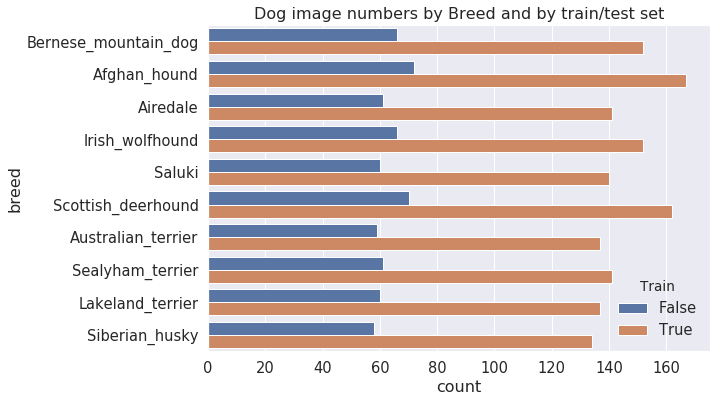

In [16]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 6))
plt.title("Dog image numbers by Breed and by train/test set")
ax = sns.countplot(y="breed", hue="Train", data=df_dogs)

## Keras Neural Network from scratch

Just the first part : Neural Network Structure before fitting process

In [94]:
nb_breeds

3

In [95]:
X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs,
  X, list_X_classes=np.array(range(nb_breeds)))
print("X_train ",X_train.shape)
print("X_test ",X_test.shape)
print("Y_train ",Y_train.shape)
print("Y_test ",Y_test.shape)

X_train  (460, 224, 224, 3)
X_test  (199, 224, 224, 3)
Y_train  (460, 3)
Y_test  (199, 3)


In [0]:
my_VGG16 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16.name = 'my_VGG16'
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16.add(Conv2D(16, (5, 5), input_shape=(224, 224, 3), padding='same', 
                    activation='relu'))

# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16.add(Conv2D(16, (5, 5), padding='same', activation='relu'))

# Ajout de la première couche de pooling
#my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # original
my_VGG16.add(MaxPooling2D(pool_size=(32,32), strides=(32,32))) # test
my_VGG16.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16.add(Dense(100, activation='relu'))

# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
#my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16.add(Dense(nb_breeds, activation='softmax'))

In [104]:
my_VGG16.summary()

Model: "my_VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 224, 224, 16)      1216      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 224, 224, 16)      6416      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_48 (Dense)             (None, 3)                 303       
Total params: 86,435
Trainable params: 86,435
Non-trainable params: 0
______________________________________________________

In [105]:
sgd_2 = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True) 

my_VGG16.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])

epochs = 100
batch_size = None
t_fit_0 = time.time()

model_info = my_VGG16.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2)
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

Epoch 1/100
 - 2s - loss: 9.1943 - acc: 0.3913
Epoch 2/100
 - 1s - loss: 8.0762 - acc: 0.4478
Epoch 3/100
 - 1s - loss: 8.2141 - acc: 0.4609
Epoch 4/100
 - 1s - loss: 8.0579 - acc: 0.4761
Epoch 5/100
 - 1s - loss: 9.3845 - acc: 0.4022
Epoch 6/100
 - 1s - loss: 8.7930 - acc: 0.4413
Epoch 7/100
 - 1s - loss: 8.4416 - acc: 0.4652
Epoch 8/100
 - 1s - loss: 7.8519 - acc: 0.5043
Epoch 9/100
 - 1s - loss: 7.6396 - acc: 0.5109
Epoch 10/100
 - 1s - loss: 8.2135 - acc: 0.4739
Epoch 11/100
 - 1s - loss: 8.8605 - acc: 0.4370
Epoch 12/100
 - 1s - loss: 7.6608 - acc: 0.4935
Epoch 13/100
 - 1s - loss: 7.2232 - acc: 0.5391
Epoch 14/100
 - 1s - loss: 7.1723 - acc: 0.5304
Epoch 15/100
 - 1s - loss: 7.5850 - acc: 0.5152
Epoch 16/100
 - 1s - loss: 7.4765 - acc: 0.5261
Epoch 17/100
 - 1s - loss: 7.5188 - acc: 0.5217
Epoch 18/100
 - 1s - loss: 7.0233 - acc: 0.5500
Epoch 19/100
 - 1s - loss: 6.9203 - acc: 0.5609
Epoch 20/100
 - 1s - loss: 6.8784 - acc: 0.5674
Epoch 21/100
 - 1s - loss: 6.7238 - acc: 0.5652
E

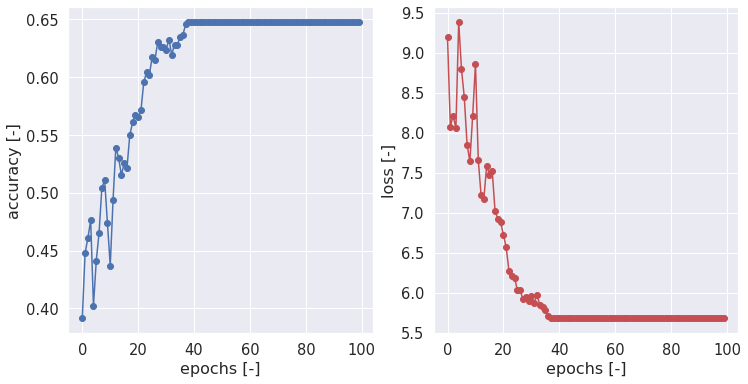

In [106]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(range(0, len(model_info.history["acc"])), model_info.history["acc"],
         'o-')
ax1.set_xlabel("epochs [-]")
ax1.set_ylabel("accuracy [-]")
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel("epochs [-]")
ax2.set_ylabel("loss [-]")
ax2.plot(range(0, len(model_info.history['loss'])), model_info.history["loss"],
         'ro-')


## Keras : Use of VGG-16 pre-trained

#### Instance of neural network class

In [0]:
model = VGG16() # Création du modèle VGG-16 implementé par Keras
#model.get_weights()[-1][:10]
model.summary()





553467904/553467096 [==============================] - 34s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________

#### Create features Train/Test

Need to re-create Y with 1000 classes

In [0]:
list_Y_classes = get_imagenet_classes()
X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs, 
  X,
  list_Y_classes=list_Y_classes)

print("X_train ",X_train.shape)
print("X_test ",X_test.shape)
print("Y_train ",Y_train.shape)
print("Y_test ",Y_test.shape)

X_train  (460, 224, 224, 3)
X_test  (199, 224, 224, 3)
Y_train  (460, 1000)
Y_test  (199, 1000)


#### Evaluate

In [0]:
# predict as binary labels
t_pred_0 = time.time()
Y_train_pred = model.predict(X_train)
t_pred_1 = time.time()
# predict as binary labels
t_pred_2 = time.time()
Y_test_pred = model.predict(X_test)
t_pred_3 = time.time()

In [0]:
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
  timing_fit=0, timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

In [0]:
df_results = add_score(df_results, series_scores, model.name)
df_results

create df_results


,acc_train,acc_test,t_fit,t_pred
vgg16,0.88913,0.874372,0.0,6.108888


In [0]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print("df_results Saved here:\n{}".format(path_df_results))

df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


In [0]:

'''# check scores
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("precision: ", precision_score(Y_test_num, Y_test_pred_num, 
                                     average='micro'))
print("recall: ", recall_score(Y_test_num, Y_test_pred_num, 
                                  average='micro'))
print("f1: ", f1_score(Y_test_num, Y_test_pred_num, 
                                  average='micro'))'''

'# check scores\nfrom sklearn.metrics import precision_score\nfrom sklearn.metrics import recall_score\nfrom sklearn.metrics import f1_score\n\nprint("precision: ", precision_score(Y_test_num, Y_test_pred_num, \n                                     average=\'micro\'))\nprint("recall: ", recall_score(Y_test_num, Y_test_pred_num, \n                                  average=\'micro\'))\nprint("f1: ", f1_score(Y_test_num, Y_test_pred_num, \n                                  average=\'micro\'))'

#### Predict from images

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/Images/n02107683-Bernese_mountain_dog/n02107683_1248.jpg
40960/35363 [==================================] - 0s 0us/step
VGG-16 : Top 3 : [('n02107683', 'Bernese_mountain_dog', 0.88926965), ('n02107908', 'Appenzeller', 0.058453113), ('n02108000', 'EntleBucher', 0.029208401)]
[('n02107683', 'Bernese_mountain_dog', 0.88926965), ('n02107908', 'Appenzeller', 0.058453113), ('n02108000', 'EntleBucher', 0.029208401)]


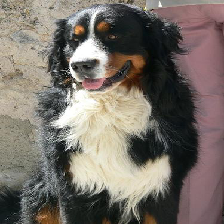

In [0]:
path_img = df_dogs[df_dogs["Train"] == False]["path"].values[0]
breedName, img_raw = predict_breed_from_one_path(path_img, model)
img_raw

Try to predict a picture from internet :

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Bernese_mountain_dog_01.jpg
VGG-16 : Top 3 : [('n02107683', 'Bernese_mountain_dog', 0.97569275), ('n02107908', 'Appenzeller', 0.017292695), ('n02108000', 'EntleBucher', 0.004781216)]
[('n02107683', 'Bernese_mountain_dog', 0.97569275), ('n02107908', 'Appenzeller', 0.017292695), ('n02108000', 'EntleBucher', 0.004781216)]


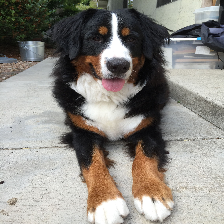

In [0]:
path_img = path_data + '/image_internet_test/Bernese_mountain_dog_01.jpg'
breedName, img_raw = predict_breed_from_one_path(path_img, model)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Afghan_hound_01.png
VGG-16 : Top 3 : [('n02088094', 'Afghan_hound', 0.9959006), ('n02105251', 'briard', 0.0018045893), ('n02097474', 'Tibetan_terrier', 0.0016100357)]
[('n02088094', 'Afghan_hound', 0.9959006), ('n02105251', 'briard', 0.0018045893), ('n02097474', 'Tibetan_terrier', 0.0016100357)]


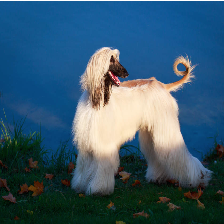

In [0]:
path_img = path_data + '/image_internet_test/Afghan_hound_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, model)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Airedale_01.png
VGG-16 : Top 3 : [('n02096051', 'Airedale', 0.56952333), ('n02091635', 'otterhound', 0.3059206), ('n02093991', 'Irish_terrier', 0.066529915)]
[('n02096051', 'Airedale', 0.56952333), ('n02091635', 'otterhound', 0.3059206), ('n02093991', 'Irish_terrier', 0.066529915)]


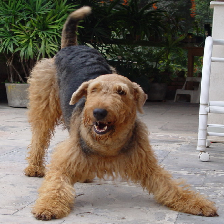

In [0]:
path_img = path_data + '/image_internet_test/Airedale_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, model)
img_raw

## Transfer Learning with Keras

### Stratégie #2 : extraction de features

#### Load data

In [0]:
df_dogs, X, dict_breed = import_data(paths_images_breeds, 
                                     train_percent=train_percent, 
                                     force_import=False)
# check
print("Image matrix size : ", X.shape)
df_dogs.head()

% of Train : 69.80 %
True     460
False    199
Name: Train, dtype: int64
Image matrix size :  (660, 224, 224, 3)


,filename,path,breed,class,Train
0,n02107683_1175.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True
1,n02107683_1248.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,False
2,n02107683_1244.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True
3,n02107683_1003.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True
4,n02107683_1076.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True


In [0]:
dict_breed

{0: 'Bernese_mountain_dog', 1: 'Afghan_hound', 2: 'Airedale'}

#### Create features

In [0]:
nb_breeds

3

In [0]:
X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs,
  X, list_X_classes=np.array(range(nb_breeds)))
print("X_train ",X_train.shape)
print("X_test ",X_test.shape)
print("Y_train ",Y_train.shape)
print("Y_test ",Y_test.shape)

X_train  (460, 224, 224, 3)
X_test  (199, 224, 224, 3)
Y_train  (460, 3)
Y_test  (199, 3)


#### Load VGG16 model without FC layers

In [0]:
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model_trans = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# we don't train layers 
for layer in model_trans.layers:
   layer.trainable = False

58892288/58889256 [==============================] - 5s 0us/step


In [0]:
model_trans.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Prepare new layers

In [0]:
# Récupérer la sortie de ce réseau
x = model_trans.output
flatten = Flatten()(x)
# Ajouter la nouvelle couche fully-connected pour la classification à 3 classes
predictions = Dense(nb_breeds, activation='softmax')(flatten)

In [0]:
model_trans.layers[-1].trainable

False

#### Update Model

In [0]:
# Définir le nouveau modèle
new_model_2 = Model(inputs=model_trans.input, outputs=predictions)
new_model_2.name = name_new_model_2

In [0]:
new_model_2.summary()

Model: "VGG16_TL_class_01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128) 

In [0]:
new_model_2.layers[-1].trainable

True

#### Train

In [0]:
# Compiler le modèle 
#sgd_2 = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True) #1s - loss: 9.3559 - acc: 0.3130
#sgd_2 = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #1s - loss: 8.8677 - acc: 0.3283
#sgd_2 = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True) #1s - loss: 9.1719 - acc: 0.3087

#Epoch 10/450 - 1s - loss: 0.2803 - acc: 0.9826
sgd_2 = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True) 

#sgd_2 = optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True) #1s - loss: 9.4899 - acc: 0.3196
#sgd_2 = optimizers.SGD(lr=0.0001, momentum=0.9) #1s - loss: 7.7716 - acc: 0.3739

new_model_2.compile(loss="categorical_crossentropy", 
                  optimizer=sgd_2, 
                  metrics=["accuracy"])

In [0]:
last_layer = new_model_2.layers[-1]

In [0]:
last_layer.get_weights()

[array([[-0.0011093 ,  0.0147172 , -0.00778152],
        [-0.00392097, -0.01331401,  0.0096108 ],
        [-0.01423161,  0.01523098,  0.0150908 ],
        ...,
        [ 0.00476171,  0.0132014 , -0.00425909],
        [ 0.00564312,  0.00750749, -0.00954446],
        [ 0.01339865, -0.00591823, -0.00125518]], dtype=float32),
 array([0., 0., 0.], dtype=float32)]

In [0]:
# Entraîner sur les données d'entraînement (X_train, y_train)
#Epoch 10/450 - 1s - loss: 0.2803 - acc: 0.9826
epochs = 15
batch_size = None
t_fit_0 = time.time()
model_info = new_model_2.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2)
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
 - 1s - loss: 2.6407 - acc: 0.8022
Epoch 2/15
 - 1s - loss: 0.7589 - acc: 0.9478
Epoch 3/15
 - 1s - loss: 0.8042 - acc: 0.9435
Epoch 4/15
 - 1s - loss: 0.5578 - acc: 0.9652
Epoch 5/15
 - 1s - loss: 0.4634 - acc: 0.9696
Epoch 6/15
 - 1s - loss: 0.4238 - acc: 0.9717
Epoch 7/15
 - 1s - loss: 0.4679 - acc: 0.9696
Epoch 8/15
 - 1s - loss: 0.3532 - acc: 0.9739
Epoch 9/15
 - 1s - loss: 0.2494 - acc: 0.9826
Epoch 10/15
 - 1s - loss: 0.1752 - acc: 0.9891
Epoch 11/15
 - 1s - loss: 0.1752 - acc: 0.9891
Epoch 12/15
 - 1s - loss: 0.1753 - acc: 0.9891
Epoch 13/15
 - 1s - loss: 0.1752 - acc: 0.9891
Epoch 14/15
 - 1s - loss: 0.1752 - acc: 0.9891
Epoch 15/15
 - 1s - loss: 0.1752 - acc: 0.9891
Timing:  17.704999923706055


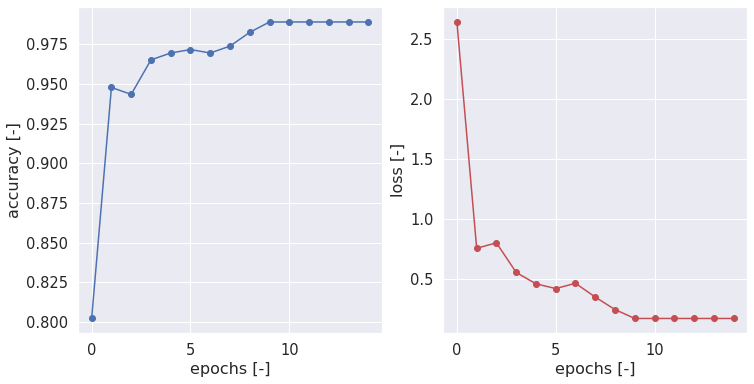

In [0]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(range(0, len(model_info.history["acc"])), model_info.history["acc"],
         'o-')
ax1.set_xlabel("epochs [-]")
ax1.set_ylabel("accuracy [-]")
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel("epochs [-]")
ax2.set_ylabel("loss [-]")
ax2.plot(range(0, len(model_info.history['loss'])), model_info.history["loss"],
         'ro-')


In [0]:
a = new_model_2.get_weights()
a[-1]

array([-6.519014e-05, -1.365955e-07,  6.532674e-05], dtype=float32)

#### Save model

In [0]:
# save
joblib.dump(new_model_2, path_model_2, compress=True)

['/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/VGG16_TL_class_01.pkl']

#### Evaluate

In [0]:
Y_train.shape

(460, 3)

In [0]:
score_train = new_model_2.evaluate(X_train, Y_train, batch_size=16)
score_train

460/460 [==============================] - 2s 4ms/step


[0.17519680831744497, 0.9891304347826086]

In [0]:
score_test = new_model_2.evaluate(X_test, Y_test, batch_size=16)
score_test

199/199 [==============================] - 1s 3ms/step


[0.324590337024565, 0.9798994977869581]

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

Loading from disk df_results...


In [0]:
# predict as binary labels
t_pred_0 = time.time()
Y_train_pred = new_model_2.predict(X_train)
t_pred_1 = time.time()
# predict as binary labels
t_pred_2 = time.time()
Y_test_pred = new_model_2.predict(X_test)
t_pred_3 = time.time()

In [0]:
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
  timing_fit=t_fit_1 - t_fit_0, timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

In [0]:
df_results = add_score(df_results, series_scores, new_model_2.name)
df_results

add line


,acc_train,acc_test,t_fit,t_pred
vgg16,0.88913,0.874372,0.000,6.108888
VGG16_TL_class_01,0.98913,0.979899,17.705,1.689842


In [0]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print("df_results Saved here:\n{}".format(path_df_results))

df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


#### Compare

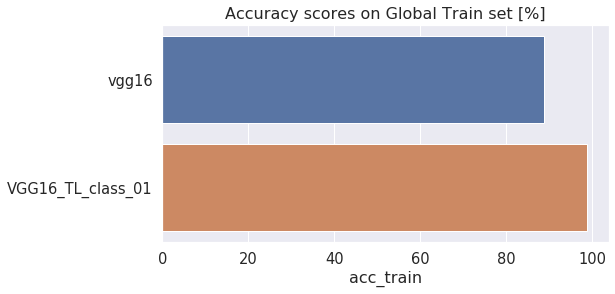

In [0]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Train set [%]")
ax = sns.barplot(
    y=df_results.sort_values(by="acc_train").index,
    x=100*df_results.sort_values(by="acc_train")["acc_train"], orient="h")

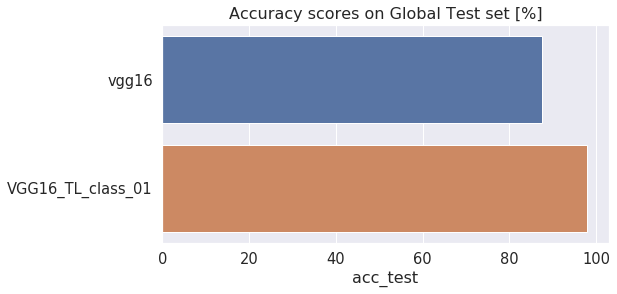

In [0]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Test set [%]")
ax = sns.barplot(
    y=df_results.sort_values(by="acc_test").index,
    x=100*df_results.sort_values(by="acc_test")["acc_test"], orient="h")

#### Predict

Try to predict picture 

##### Load model

In [0]:
new_model_2 = joblib.load(path_model_2)

##### Predict from image

In [0]:
dict_breed

{0: 'Bernese_mountain_dog', 1: 'Afghan_hound', 2: 'Airedale'}

from data set :

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/Images/n02107683-Bernese_mountain_dog/n02107683_1248.jpg
Probabilities :  [[1. 0. 0.]]
Bernese_mountain_dog


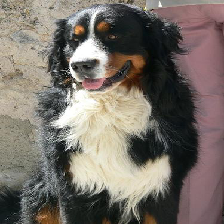

In [0]:
path_img = df_dogs[df_dogs["Train"] == False]["path"].values[0]
breedName, img_raw = predict_breed_from_one_path(path_img, new_model_2)
img_raw

Try to predict a picture from internet :

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Bernese_mountain_dog_01.jpg
Probabilities :  [[1. 0. 0.]]
Bernese_mountain_dog


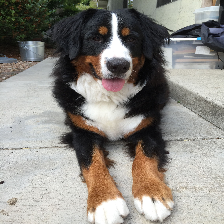

In [0]:
path_img = path_data + '/image_internet_test/Bernese_mountain_dog_01.jpg'
breedName, img_raw = predict_breed_from_one_path(path_img, new_model_2)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Afghan_hound_01.png
Probabilities :  [[0. 1. 0.]]
Afghan_hound


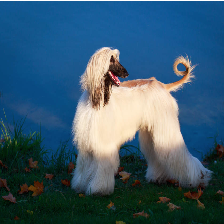

In [0]:
path_img = path_data + '/image_internet_test/Afghan_hound_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, new_model_2)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Airedale_01.png
Probabilities :  [[0. 0. 1.]]
Airedale


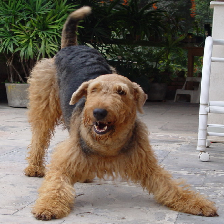

In [0]:
path_img = path_data + '/image_internet_test/Airedale_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, new_model_2)
img_raw

#### Number of breeds impact

In [0]:
nb_breeds = 4
paths_images_breeds = paths_images_all_breeds[:nb_breeds]
print("paths_images_breeds: ", paths_images_breeds)

paths_images_breeds:  ['Images/n02107683-Bernese_mountain_dog/', 'Images/n02088094-Afghan_hound/', 'Images/n02096051-Airedale/', 'Images/n02090721-Irish_wolfhound']


In [0]:
re.findall('\w+(?=/$)', "Irish_wolfhound")

[]

In [0]:
df_dogs, X, dict_breed = import_data(paths_images_breeds, 
                                     train_percent=train_percent, 
                                     force_import=True)
# check
print("Image matrix size: ", X.shape)

print("df_dogs: ", df_dogs.head())

['Bernese_mountain_dog']
['Afghan_hound']
['Airedale']
[]


ValueError: ignored